In [117]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal

In [118]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 12

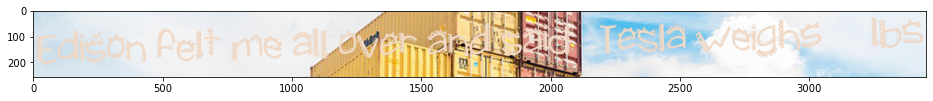

In [150]:
cvimg = cv2.imread('dataset/validation/train53.png')
rgbimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)
plt.imshow(rgbimg)

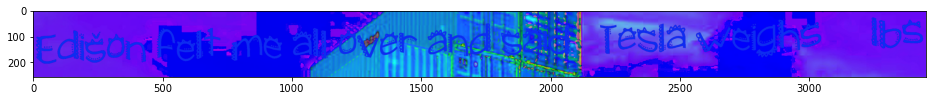

In [151]:
hsvImage = cv2.cvtColor(cvimg, cv2.COLOR_BGR2HSV)
plt.imshow(hsvImage, 'hsv')

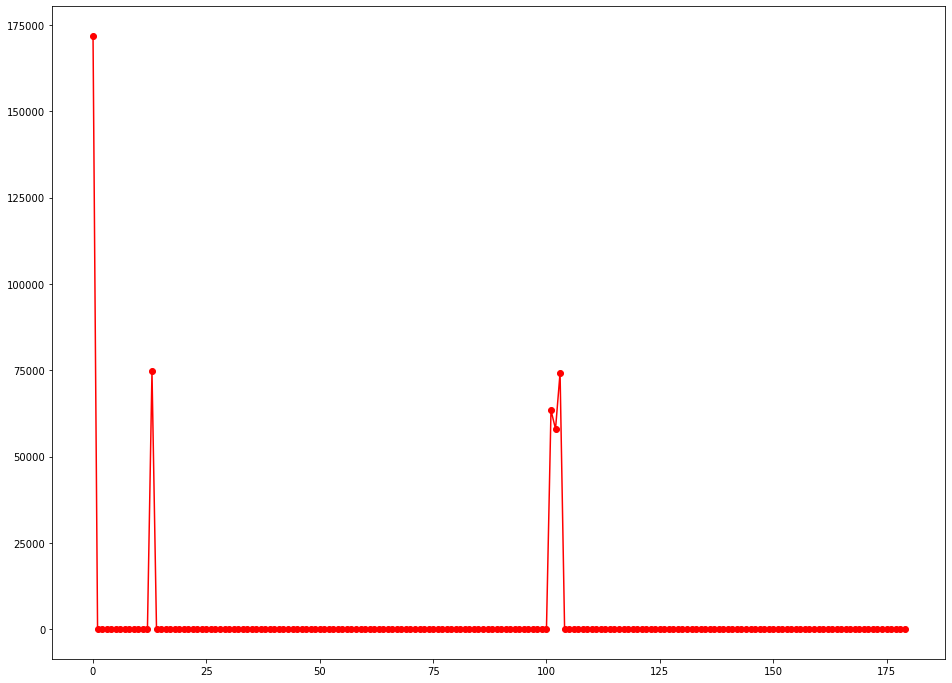

In [152]:
def hist(image):
    height, width = image.shape[0:2]
    x = range(0, 180)
    y = np.zeros(180)
    
    for i in range(0, height):
        for j in range(0, width):
            pixel = image[i, j]
            y[pixel] += 1
    
    return (x, y)

x,y = hist(hsvImage[:,:,0])
pixels = hsvImage.shape[0] * hsvImage.shape[1]
for i in range(len(y)):
    if not 0.05*pixels < y[i] < 0.3*pixels:
        y[i] = 0
plt.plot(x, y, '-or')
plt.show()

[ 13 101 103]
49780.0
40071.0
5428.0
35009.0


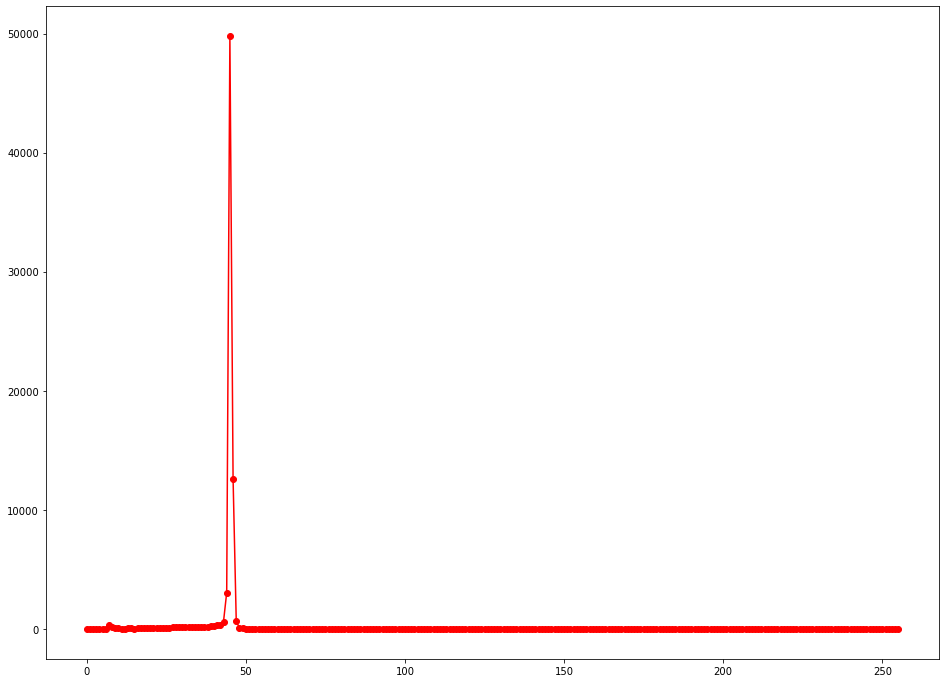

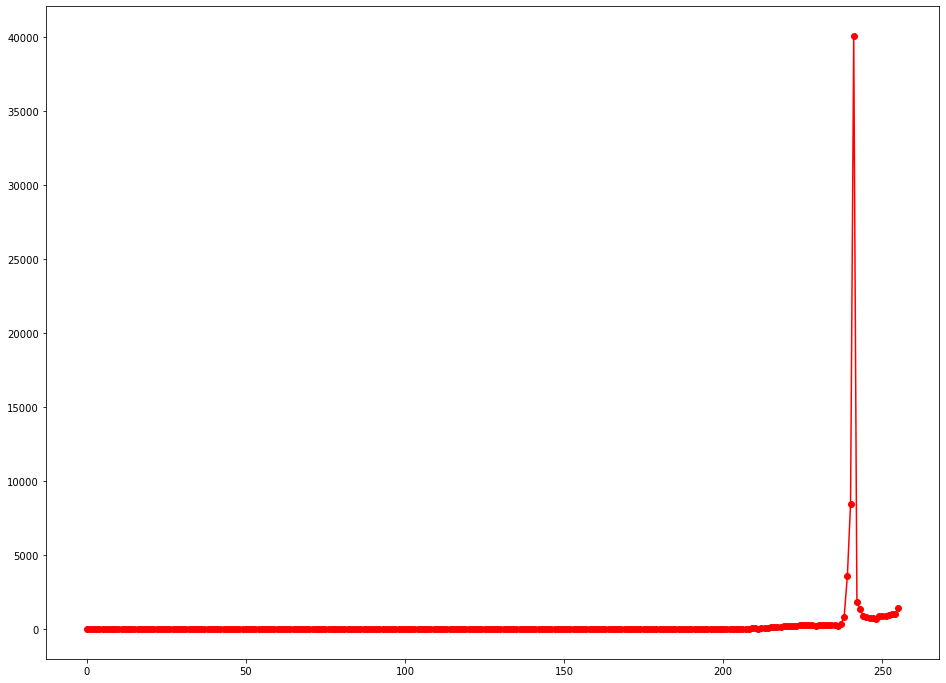

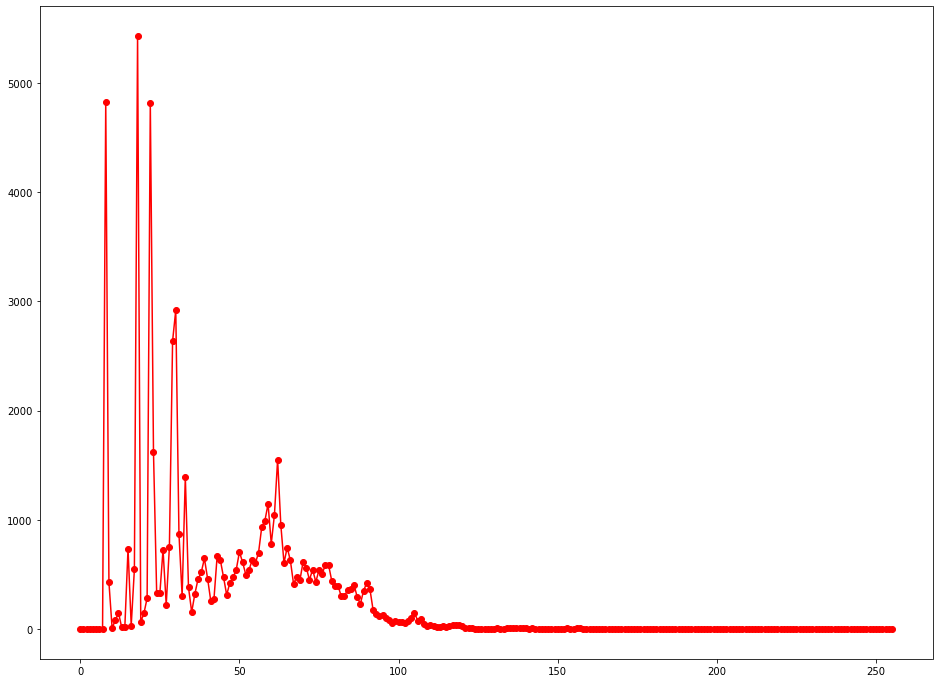

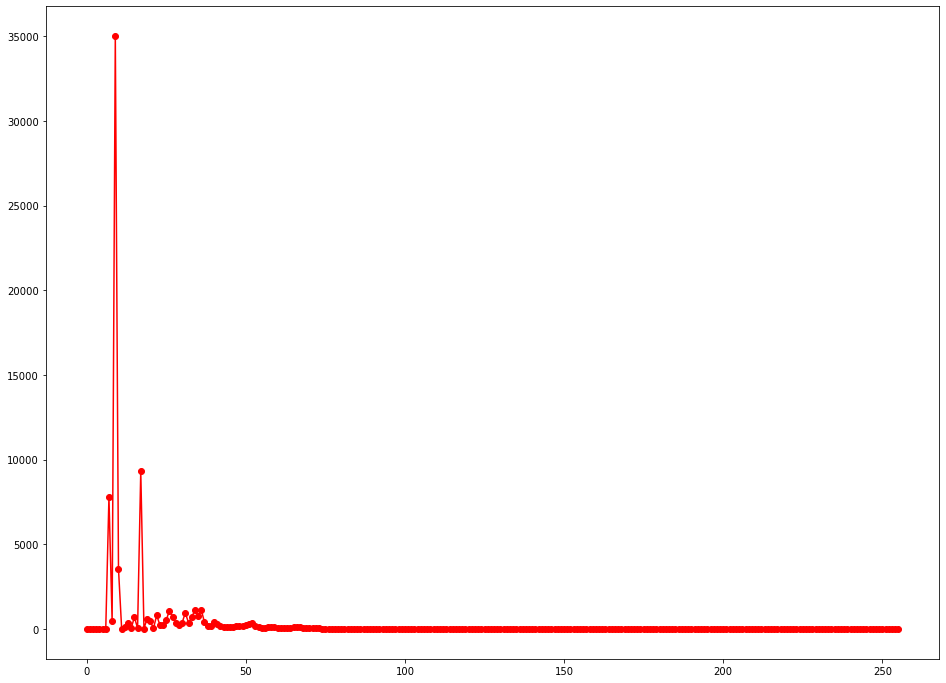

[[13, 45, 241]]


In [175]:
peaks, _ = scipy.signal.find_peaks(y)
print(peaks)
peakcandidate = []
def distincthist(image, sourcevalid):
    height, width = image.shape[0:2]
    x = range(0, 256)
    y = np.zeros(256)
    
    for i in range(0, height):
        for j in range(0, width):
            if sourcevalid[i,j]:
                pixel = image[i, j]
                y[pixel] += 1
    
    return (x, y)
for peak in peaks:
    valid = True
    hsvpeak = [peak]
    for i in range(1,3):
        xtemp,ytemp = distincthist(hsvImage[:,:,i],hsvImage[:,:,0]==peak)
        hsvpeak.append(np.argmax(ytemp))
        print(np.amax(ytemp))
        plt.figure()
        plt.plot(xtemp, ytemp, '-or')
        if (i==1 and np.amax(ytemp)<0.6*y[peak]) or (i==2 and np.amax(ytemp)<0.4*y[peak]):
            valid = False
            break
    if valid:
        peakcandidate.append(hsvpeak)
plt.show()
peakcandidate.sort(key=lambda x: x[2], reverse=True)
print(peakcandidate)

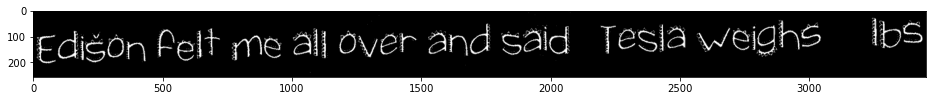

In [179]:
textimg = hsvImage[:,:,0].copy()
textimg[np.logical_or(hsvImage[:,:,0]!=peakcandidate[0][0], hsvImage[:,:,1]!=peakcandidate[0][1])] = 0
textimg[np.logical_and(hsvImage[:,:,0]==peakcandidate[0][0], hsvImage[:,:,1]==peakcandidate[0][1])] = 255
plt.imshow(textimg, 'gray')

In [181]:
img, contours, hierarchy = cv2.findContours(textimg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

2459


In [182]:
contours.sort(key=lambda x: cv2.contourArea(x), reverse=True)
exrects = []
def isInside(rectangle, contour):
    pass
def expandRect(rectangle):
    pass
i = 0
while i < len(contours):
    j = i + 1
    for rect in exrects:
        if isInside(rect[0], contours[i]):
            rect[1].append(contours[j])
            del contours[i]
            continue
    exrect = [expandRect(cv2.minAreaRect(contours[i])), []]
    while j < len(contours):
        if isInside(exrect[0], contours[j]):
            exrect[1].append(contours[j])
            del contours[j]
            continue
        j = j + 1
    exrects.append(exrect)
    i = i + 1

[array([[[1071,  239]]], dtype=int32),
 array([[[1071,  237]]], dtype=int32),
 array([[[1672,  210]]], dtype=int32),
 array([[[ 56, 203]]], dtype=int32),
 array([[[ 50, 203]],
 
        [[ 50, 204]]], dtype=int32),
 array([[[ 46, 203]]], dtype=int32),
 array([[[ 73, 200]],
 
        [[ 74, 200]]], dtype=int32),
 array([[[ 38, 200]],
 
        [[ 39, 199]],
 
        [[ 40, 200]],
 
        [[ 39, 201]]], dtype=int32),
 array([[[422, 198]]], dtype=int32),
 array([[[226, 197]],
 
        [[227, 196]],
 
        [[228, 196]],
 
        [[229, 197]],
 
        [[228, 198]],
 
        [[227, 198]]], dtype=int32),
 array([[[ 46, 197]],
 
        [[ 47, 196]],
 
        [[ 48, 197]],
 
        [[ 47, 198]]], dtype=int32),
 array([[[ 87, 196]]], dtype=int32),
 array([[[ 68, 196]],
 
        [[ 69, 195]],
 
        [[ 71, 195]],
 
        [[ 72, 196]],
 
        [[ 71, 197]],
 
        [[ 69, 197]]], dtype=int32),
 array([[[ 56, 196]]], dtype=int32),
 array([[[ 40, 196]],
 
        [[ 41, 195]]

In [ ]:
rois = []
for rect in exrect:
    ptsvector = []
    for c in rect[1]:
        for vec in c:
            ptsvector.append(vec)
    roi = cv2.minAreaRect(ptsvector)
    rois.append(roi)
#rois.sort(key=lambda x: x.center()) treba bas compare fja da se preda

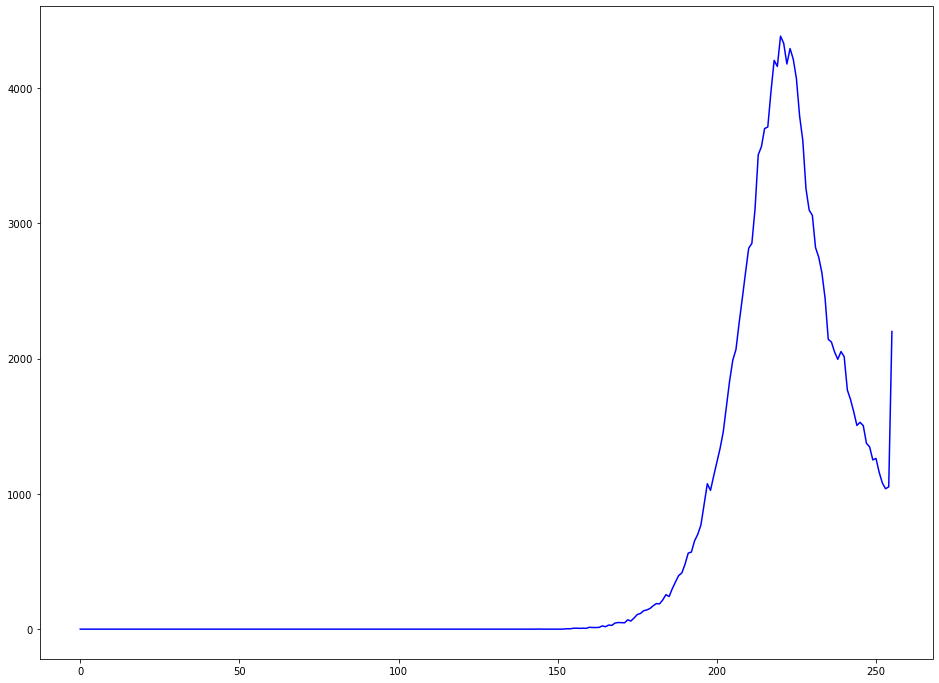

In [107]:
def hist(image):
    height, width = image.shape[0:2]
    x = range(0, 256)
    y = np.zeros(256)
    
    for i in range(0, height):
        for j in range(0, width):
            pixel = image[i, j]
            if pixel!=7: y[pixel] += 1
    
    return (x, y)
tmp = hsvImage.copy()
tmp[tmp[:,:,0]<99] = [0,0,7]
tmp[tmp[:,:,0]>99] = [0,0,7]
x,y = hist(tmp[:,:,2])

#print(tmp[:,:,1][tmp[:,:,1]==0])
plt.plot(x, y, 'b')
plt.show()

99


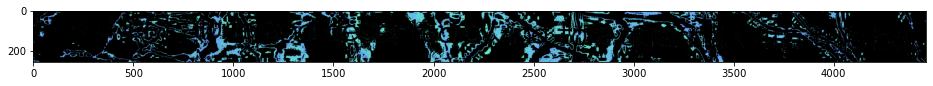

In [58]:
tmp = hsvImage.copy()
print(np.argmax(y))
tmp[tmp[:,:,0]!=np.argmax(y)] = [0,0,0]
#tmp[tmp[:,:,0]>50] = [0,0,0]
#tmp[tmp!=0] = 255
plt.imshow(tmp)

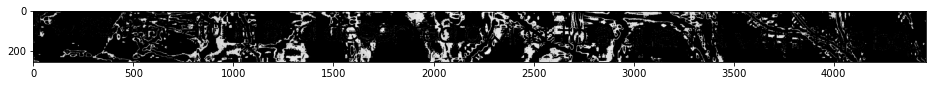

In [49]:
gsimg = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
plt.imshow(gsimg, 'gray')

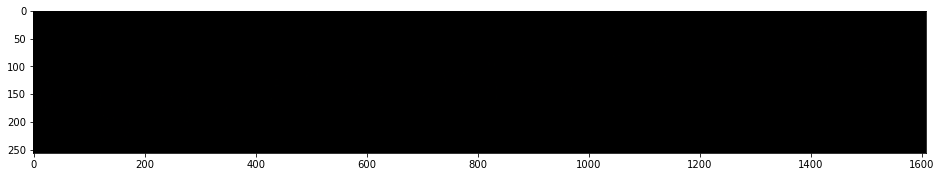

In [19]:
tmp = hsvImage.copy()
tmp[tmp<0] = 0
tmp[tmp>5] = 0
#tmp[tmp!=17] = 0
plt.imshow(tmp, 'gray')

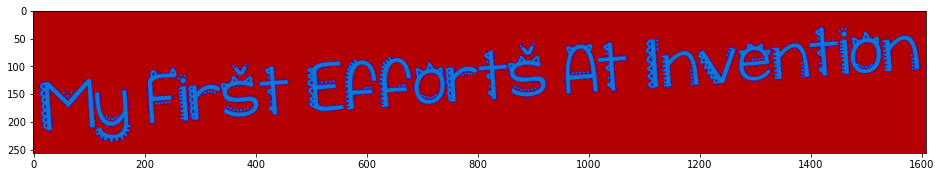

In [24]:
tmp = hsvImage.copy()
tmp[tmp[:,:,0]<10] = [179,0,0]
tmp[tmp[:,:,0]>50] = [179,0,0]
#tmp[tmp!=0] = 255
plt.imshow(tmp)

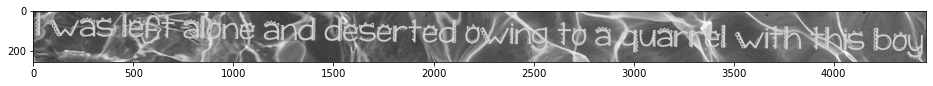

In [10]:
gsimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2GRAY)
plt.imshow(gsimg, 'gray')

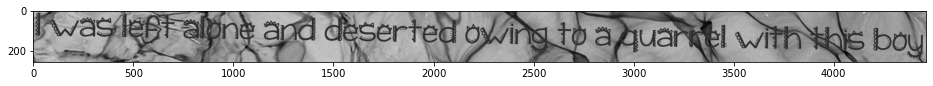

In [196]:
invimg = 255 - gsimg
plt.imshow(invimg, 'gray')

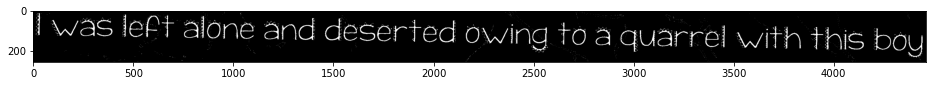

In [197]:
tmp = invimg.copy()
tmp[tmp<39] = 0
tmp[tmp>39] = 0
tmp[tmp!=0] = 255
plt.imshow(tmp, 'gray')

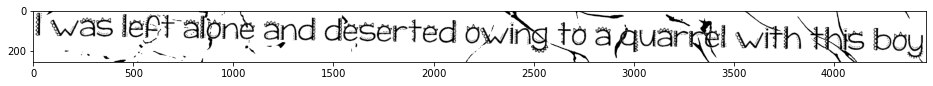

In [167]:
_, binimg = cv2.threshold(invimg, 40, 255, cv2.THRESH_BINARY)
plt.imshow(binimg, 'gray')

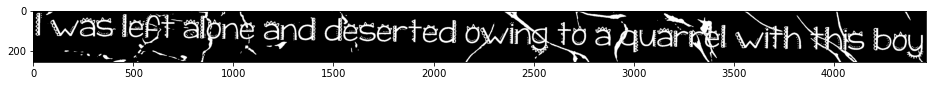

In [159]:
invbinimg = 255 - binimg
plt.imshow(invbinimg, 'gray')

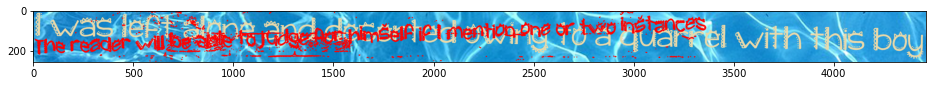

In [135]:
img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(rgbimg, contours, -1, (255, 0, 0), 3)
plt.imshow(rgbimg)